In [3]:
#!/usr/bin/env python3
#pip install  rioxarray==0.3.1
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import rioxarray
import numpy as np
import geopandas as gpd
import cartopy.crs as ccrs
import rasterio
import os
import matplotlib.colors
scriptsdir = os.getcwd()
from scipy.interpolate import griddata
from functools import reduce
import xarray
import itertools
import matplotlib.colors as mcolors
import matplotlib.colors as colors
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.gridspec as gridspec
import cartopy.feature as cfeature
import warnings

NameError: name 'percent_changes' is not defined

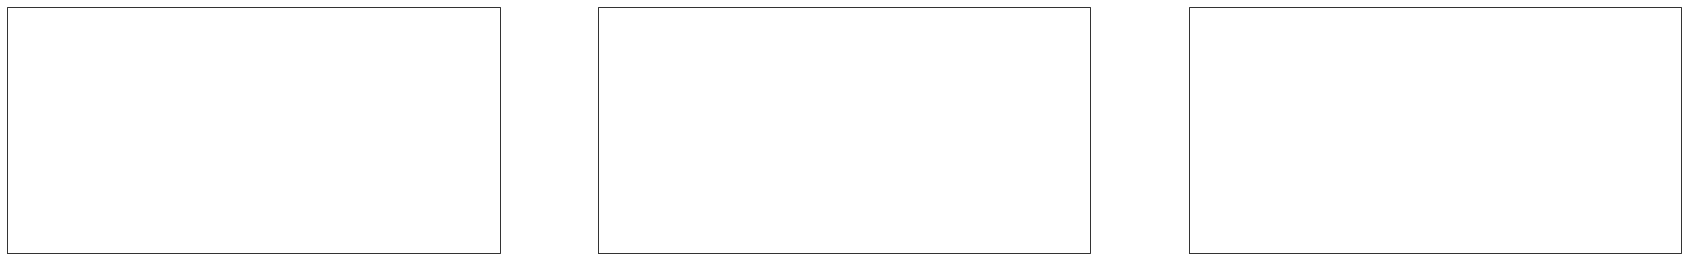

In [5]:
import warnings
import matplotlib.pyplot as plt
import matplotlib.colors
import geopandas as gpd
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import BoundaryNorm

warnings.filterwarnings('ignore', category=UserWarning)

# Define constants
models = ["GAM", "GBM"]
taxas = ["Amphibians","Bird", "Mammals"]
scenarios = ["rcp26","rcp60"]
model_names = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
year_indices = {1146: '1995', 35: '2050', 65: '2080', 85: '2100'}

# Setup plot
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(30, 15), subplot_kw={'projection': ccrs.PlateCarree()})
countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

diff_combined_all_scenarios = []
# Extract and plot data for each scenario
for idx, scenario in enumerate(scenarios):
    diff_value_bin_combined_per_taxa = {taxa: np.zeros([360, 720]) for taxa in taxas}
    diff_sum_bin_combined_per_taxa = {taxa: np.zeros([360, 720]) for taxa in taxas}
    diff_combined_per_taxa = {taxa: np.zeros([360, 720]) for taxa in taxas}

    for taxa in taxas:
        historical_time = 1146
        future_times = [65]

        for future_time in future_times:
            diff_value_bin_models = []
            diff_sum_bin_models = []
            diff_models = []

            for model in models:
                newvalue_hist = f"/storage/scratch/users/ch21o450/data/SR/{taxa}_{model}_{historical_time}_summedprobs_newvalue.nc"
                sumbin_hist = f"/storage/scratch/users/ch21o450/data/SR/{taxa}_{model}_{historical_time}_summedprobs_sum.nc"


                mean_value_bin_hist = xr.open_dataset(newvalue_hist, decode_times=False).to_array().isel(variable=0)
                mean_sum_bin_hist = xr.open_dataset(sumbin_hist, decode_times=False).to_array().isel(time=0)

                newvalue_fut = f"/storage/scratch/users/ch21o450/data/SR/{taxa}_{model}_{future_time}_{scenario}_summedprobs_newvalue.nc"
                sumbin_fut = f"/storage/scratch/users/ch21o450/data/SR/{taxa}_{model}_{future_time}_{scenario}_summedprobs_sum.nc"


                mean_value_bin_future = xr.open_dataset(newvalue_fut, decode_times=False).to_array()
                mean_sum_bin_future = xr.open_dataset(sumbin_fut, decode_times=False).to_array()
                mean_sum_bin_future = mean_sum_bin_future.isel(variable=0)

                # Calculate the differences
                diff_value_bin = mean_value_bin_future - mean_value_bin_hist
                diff_sum_bin = mean_sum_bin_future.isel(time=0) - mean_sum_bin_hist.isel(variable=0)
                diff = diff_sum_bin - diff_value_bin
                change_percent = ((diff_sum_bin - diff_value_bin) / (diff_value_bin)) * 100  # added small value to avoid division by zero
                percent_changes.append(change_percent)

                # append the differences to the model-specific lists
                diff_value_bin_models.append(diff_value_bin)
                diff_sum_bin_models.append(diff_sum_bin)
                diff_models.append(diff)

            # Calculate the ensemble mean outside of the inner loop
            diff_value_bin_ensemble = xr.concat(diff_value_bin_models, dim="ensemble").mean(dim="ensemble")
            diff_sum_bin_ensemble = xr.concat(diff_sum_bin_models, dim="ensemble").mean(dim="ensemble")

            diff_value_bin_ensemble = diff_value_bin_ensemble.isel(variable=0)
            diff_sum_bin_ensemble = diff_sum_bin_ensemble
            diff_ensemble = diff_sum_bin_ensemble - diff_value_bin_ensemble

            # Append the ensemble mean to the overall results for this taxa
            diff_value_bin_combined_per_taxa[taxa] = diff_value_bin_ensemble
            diff_sum_bin_combined_per_taxa[taxa] = diff_sum_bin_ensemble
            diff_combined_per_taxa[taxa] = diff_ensemble

    # Calculate the overall species richness sum over all taxa
    diff_value_bin_combined = sum(diff_value_bin_combined_per_taxa.values())
    diff_sum_bin_combined = sum(diff_sum_bin_combined_per_taxa.values())
    diff_combined = sum(diff_combined_per_taxa.values())

    # Plot results
    ax = axes[idx]

    cmap = plt.colormaps['RdBu']
    boundaries = [-200, -150, -100, -50,-5,5,50, 100, 150, 200] # Adjust these values according to your data
    norm = BoundaryNorm(boundaries, cmap.N)

    im = ax.pcolormesh(diff_sum_bin_combined['lon'].values, diff_sum_bin_combined['lat'].values, np.where(diff_sum_bin_combined.values != 0, diff_sum_bin_combined.values, np.nan), transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)
    
    countries.plot(ax=ax, color="white", zorder=1, alpha=0.3)
    ax.set_title(f"CC and LUC impact: 2080 for {scenario}", loc='center')

    ax.axis('off')
    ax.set_extent((-180, 180, -63, 90))
    ax.add_feature(cfeature.BORDERS, color='white', linewidth=0.5)

    ticks = np.array( [-200, -150, -100, -50,0,50, 100, 150, 200])
    tick_labels = [str(int(tick)) for tick in ticks]

    cbar = plt.colorbar(im, ax=ax, fraction=0.024, pad=0.04, spacing='proportional', ticks=ticks, extend='both')
    cbar.set_ticklabels(tick_labels)
    
    diff_combined_all_scenarios.append(diff_sum_bin_combined)

# Compute the difference between the two scenarios
diff_between_scenarios = diff_combined_all_scenarios[1] - diff_combined_all_scenarios[0]

# Plot the difference in the third subplot
ax = axes[2]
im = ax.pcolormesh(diff_between_scenarios['lon'].values, 
                   diff_between_scenarios['lat'].values, 
                   np.where(diff_between_scenarios.values != 0, diff_between_scenarios.values, np.nan), 
                   transform=ccrs.PlateCarree(), cmap="RdBu")

countries.plot(ax=ax, color="white", zorder=1, alpha=0.3)
ax.set_title(f"Difference between scenarios", loc='center')

ax.axis('off')
ax.set_extent((-180, 180, -63, 90))
ax.add_feature(cfeature.BORDERS, color='white', linewidth=0.5)

#ticks = np.array( [0, 200, 400, 600, 800, 1000])
#tick_labels = [str(int(tick)) for tick in ticks]

cbar = plt.colorbar(im, ax=ax, fraction=0.024, pad=0.04, spacing='proportional', extend='both')
#cbar.set_ticklabels(tick_labels)


#plt.savefig("/storage/homefs/ch21o450/scripts/BioScenComb/plots/species_richness_2080")
plt.show()

ValueError: too many values to unpack (expected 2)

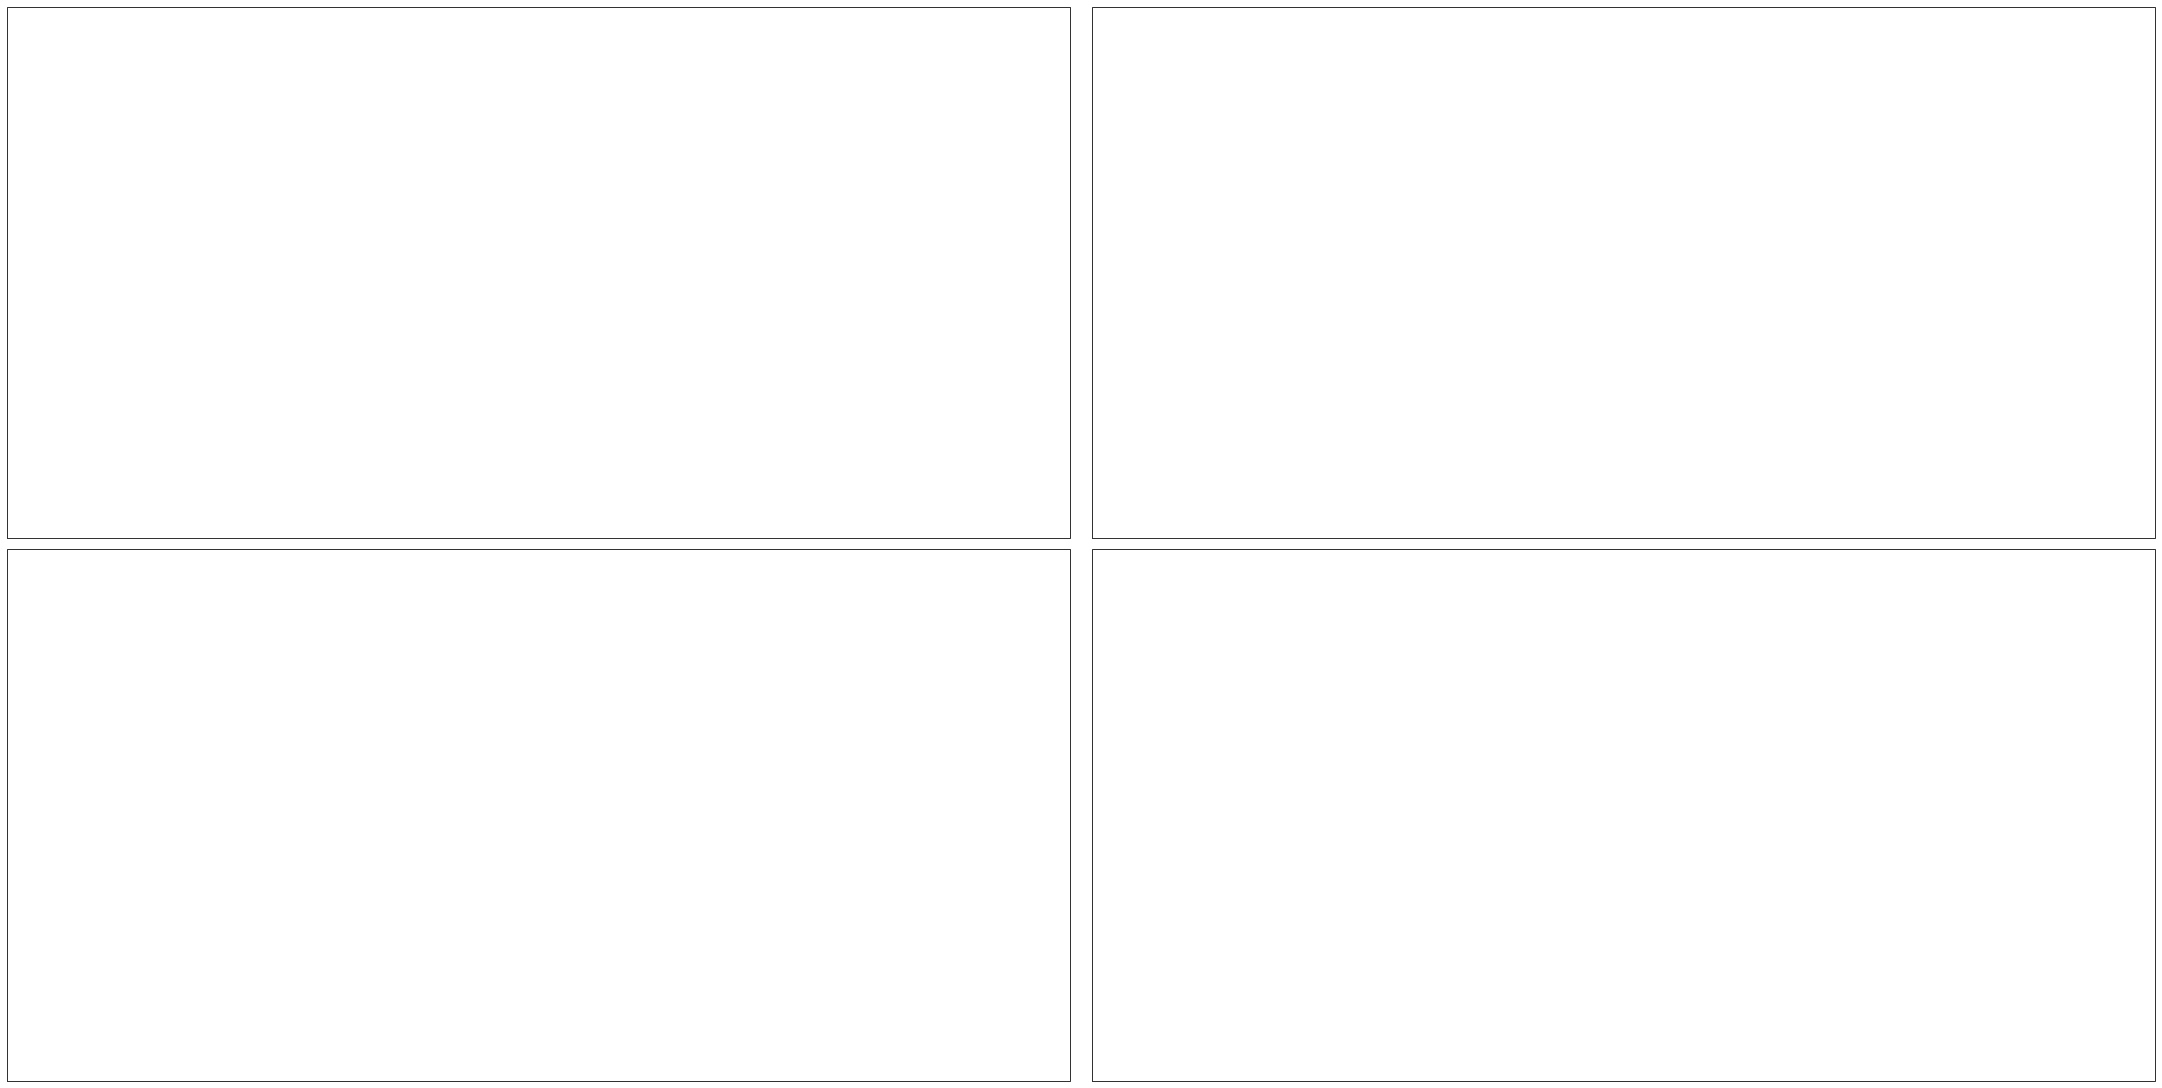

In [119]:
### this code works 

warnings.filterwarnings('ignore', category=UserWarning)

models =  ["GAM","GBM"]
taxas = ["Mammals","Bird","Amphibians"]
scenarios = ["rcp26","rcp60"]
historical_time = 1146
future_time=65
model_names = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
years = ['1845', '1990', '1995', '2009', '2010', '2020', '2026', '2032', '2048', '2050','2052', '2056', '2080', '2100', '2150', '2200', '2250']

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(30, 15), subplot_kw={'projection': ccrs.PlateCarree()}, layout="compressed")
cmap = matplotlib.colors.ListedColormap(['white', 'green'])
countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

plot_idx = 0

year_indices = {1146: '1995', 35: '2050', 65: '2080', 85: '2100'}
# Create empty arrays for storing the results for each taxa separately
diff_value_bin_combined_per_taxa = {}
diff_sum_bin_combined_per_taxa = {}
diff_combined_per_taxa = {}


for taxa in taxas:

    diff_value_bin_combined_per_taxa[taxa] = np.zeros([360, 720])
    diff_sum_bin_combined_per_taxa[taxa] = np.zeros([360, 720])
    diff_combined_per_taxa[taxa] = np.zeros([360, 720])

for row, scenario in enumerate(scenarios):

    # Initialize the combined arrays outside the taxa loop
    diff_value_bin_combined = np.zeros([360, 720])
    diff_sum_bin_combined = np.zeros([360, 720])
    diff_combined = np.zeros([360, 720])

    for taxa in taxas:
        # Reset the per model arrays for each taxa
        diff_value_bin_models = []
        diff_sum_bin_models = []
        diff_models = []

        # Your code to calculate diff for each model and taxa here
        for model in models:
            newvalue_hist = f"/storage/scratch/users/ch21o450/data/intermediate_results/{taxa}_{model}_{historical_time}_{scenario}_summedprobs_newvalue.nc"
            sumbin_hist = f"/storage/scratch/users/ch21o450/data/intermediate_results/{taxa}_{model}_{historical_time}_{scenario}_summedprobs_sum.nc"


            mean_value_bin_hist = xr.open_dataset(newvalue_hist, decode_times=False).to_array().isel(variable=0)
            mean_sum_bin_hist = xr.open_dataset(sumbin_hist, decode_times=False).to_array().isel(variable=0)

            newvalue_fut = f"/storage/scratch/users/ch21o450/data/intermediate_results/{taxa}_{model}_{future_time}_{scenario}_summedprobs_newvalue.nc"
            sumbin_fut = f"/storage/scratch/users/ch21o450/data/intermediate_results/{taxa}_{model}_{future_time}_{scenario}_summedprobs_sum.nc"


            mean_value_bin_future = xr.open_dataset(newvalue_fut, decode_times=False).to_array()
            mean_sum_bin_future = xr.open_dataset(sumbin_fut, decode_times=False).to_array()
            mean_sum_bin_future = mean_sum_bin_future

            # Calculate the differences
            diff_value_bin = mean_value_bin_future - mean_value_bin_hist
            diff_sum_bin = mean_sum_bin_future - mean_sum_bin_hist
            diff = diff_sum_bin - diff_value_bin


            # append the differences to the model-specific lists
            diff_value_bin_models.append(diff_value_bin)
            diff_sum_bin_models.append(diff_sum_bin)
            diff_models.append(diff)


        # The inner loop where diff_value_bin, diff_sum_bin, and diff for each model are calculated should remain intact.

        # Now you concatenate and take mean here for models
        diff_value_bin_ensemble = xr.concat(diff_value_bin_models, dim="ensemble").mean(dim="ensemble")
        diff_sum_bin_ensemble = xr.concat(diff_sum_bin_models, dim="ensemble").mean(dim="ensemble")
        diff_ensemble = diff_sum_bin_ensemble.isel(variable=0) - diff_value_bin_ensemble.isel(variable=0)



    # Append the ensemble mean to the overall results for this taxa
        diff_value_bin_combined_per_taxa[taxa] = diff_value_bin_ensemble
        diff_sum_bin_combined_per_taxa[taxa] = diff_sum_bin_ensemble
        diff_combined_per_taxa[taxa] = diff_ensemble

    # Calculate the overall species richness sum over all taxa
    diff_value_bin_combined = sum(diff_value_bin_combined_per_taxa.values())
    diff_sum_bin_combined = sum(diff_sum_bin_combined_per_taxa.values())
    diff_combined = sum(diff_combined_per_taxa.values())

    diff_newvalue= diff_value_bin_combined
    diff_sumbin = diff_sum_bin_combined
    diff = diff_combined

    # Create subplots for each future time and scenario
    if plot_idx >= len(axes.flatten()):
        break
    ax1 = axes.flatten()[plot_idx]
    ax2 = axes.flatten()[plot_idx + 1]

    labels = ['a', 'b']
    # Define the colormap and the range of values for the colorbar

    vmin_b = diff_sum_bin.min().values
    vmax_b = diff_sum_bin.max().values

    cmap = plt.colormaps['RdBu']
    boundaries = [-200, -150, -100, -50,-5,5,50, 100, 150, 200] # Adjust these values according to your data
    norm = BoundaryNorm(boundaries, cmap.N)

    # Plot the ensemble mean difference for each panel
    im1 = ax1.pcolormesh(diff_newvalue['lon'].values, diff_newvalue['lat'].values, np.where(diff_newvalue.values != 0, diff_newvalue.values, np.nan), transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)

    countries.plot(ax=ax1, color="white", zorder=1, alpha=0.3)
    ax1.set_title(f"Climate Change impact: {year_indices[future_time]} - 1995 for {scenario}",loc='center')

    ax1.axis('off')
    ax1.set_extent((-180,180,-63,90))
    ax1.add_feature(cfeature.BORDERS,color='white',linewidth=0.5)

    ticks_b = np.array( [-200, -150, -100, -50,0,50, 100, 150, 200])
    tick_labels = [str(int(tick)) for tick in ticks_b]

    cbar1 = plt.colorbar(im1, ax=ax1, fraction=0.024, pad=0.04, spacing='proportional', ticks=ticks_b,extend='both')
    cbar1.set_ticklabels(tick_labels)

    im2 = ax2.pcolormesh(diff_sumbin['lon'].values, diff_sumbin['lat'].values,  np.where(diff_sumbin.values != 0, diff_sumbin.values, np.nan), transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)

    countries.plot(ax=ax2, color="lightgray", zorder=1, alpha=0.3)

    ax2.set_title(f"Climate Change + Land-Use Change impact: {year_indices[future_time]} - 1995 for {scenario}",loc='center')

    ax2.axis('off')
    ax2.set_extent((-180,180,-63,90))
    cbar2 = plt.colorbar(im2, ax=ax2, fraction=0.024, pad=0.04, spacing='proportional', ticks=ticks_b,extend='both')
    cbar2.set_ticklabels(tick_labels)

    # Increase the plot index by 2 to move to the next triplet of subplots
    plot_idx += 2

    #plt.suptitle(future_time , size=16, y=0.8)
    #plt.savefig("/storage/homefs/ch21o450/scripts/BioScenComb/main_figures/Figure_2")

    #plt.show() 


In [95]:
diff_value_bin = mean_value_bin_future - mean_value_bin_hist.interp_like(mean_value_bin_future, method='linear')

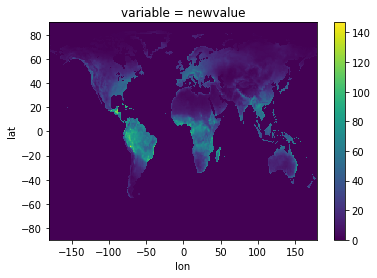

In [98]:
mean_value_bin_future.plot()

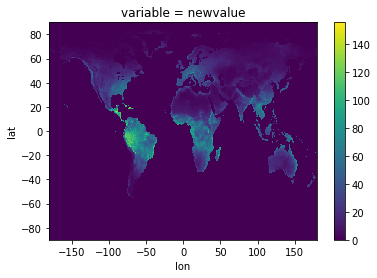

In [99]:
mean_value_bin_hist.plot()

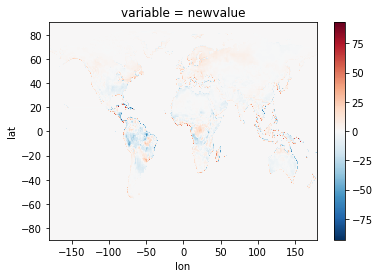

In [97]:
diff_value_bin.plot()

In [91]:
diff_sum_bin

<xarray.DataArray (lat: 0, lon: 0, variable: 1)>
array([], shape=(0, 0, 1), dtype=float64)
Coordinates:
  * lon       (lon) float64 
  * lat       (lat) float64 
  * variable  (variable) object 'sum_bin'

In [112]:
diff_sum_bin

<xarray.DataArray (lat: 0, lon: 0)>
array([], shape=(0, 0), dtype=float64)
Coordinates:
  * lon       (lon) float64 
  * lat       (lat) float64 
    variable  <U7 'sum_bin'

In [104]:
mean_sum_bin_hist

<xarray.DataArray (variable: 1, lat: 360, lon: 720)>
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])
Coordinates:
    time      float64 ...
  * lon       (lon) float64 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * lat       (lat) float64 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
  * variable  (variable) object 'sum_bin'

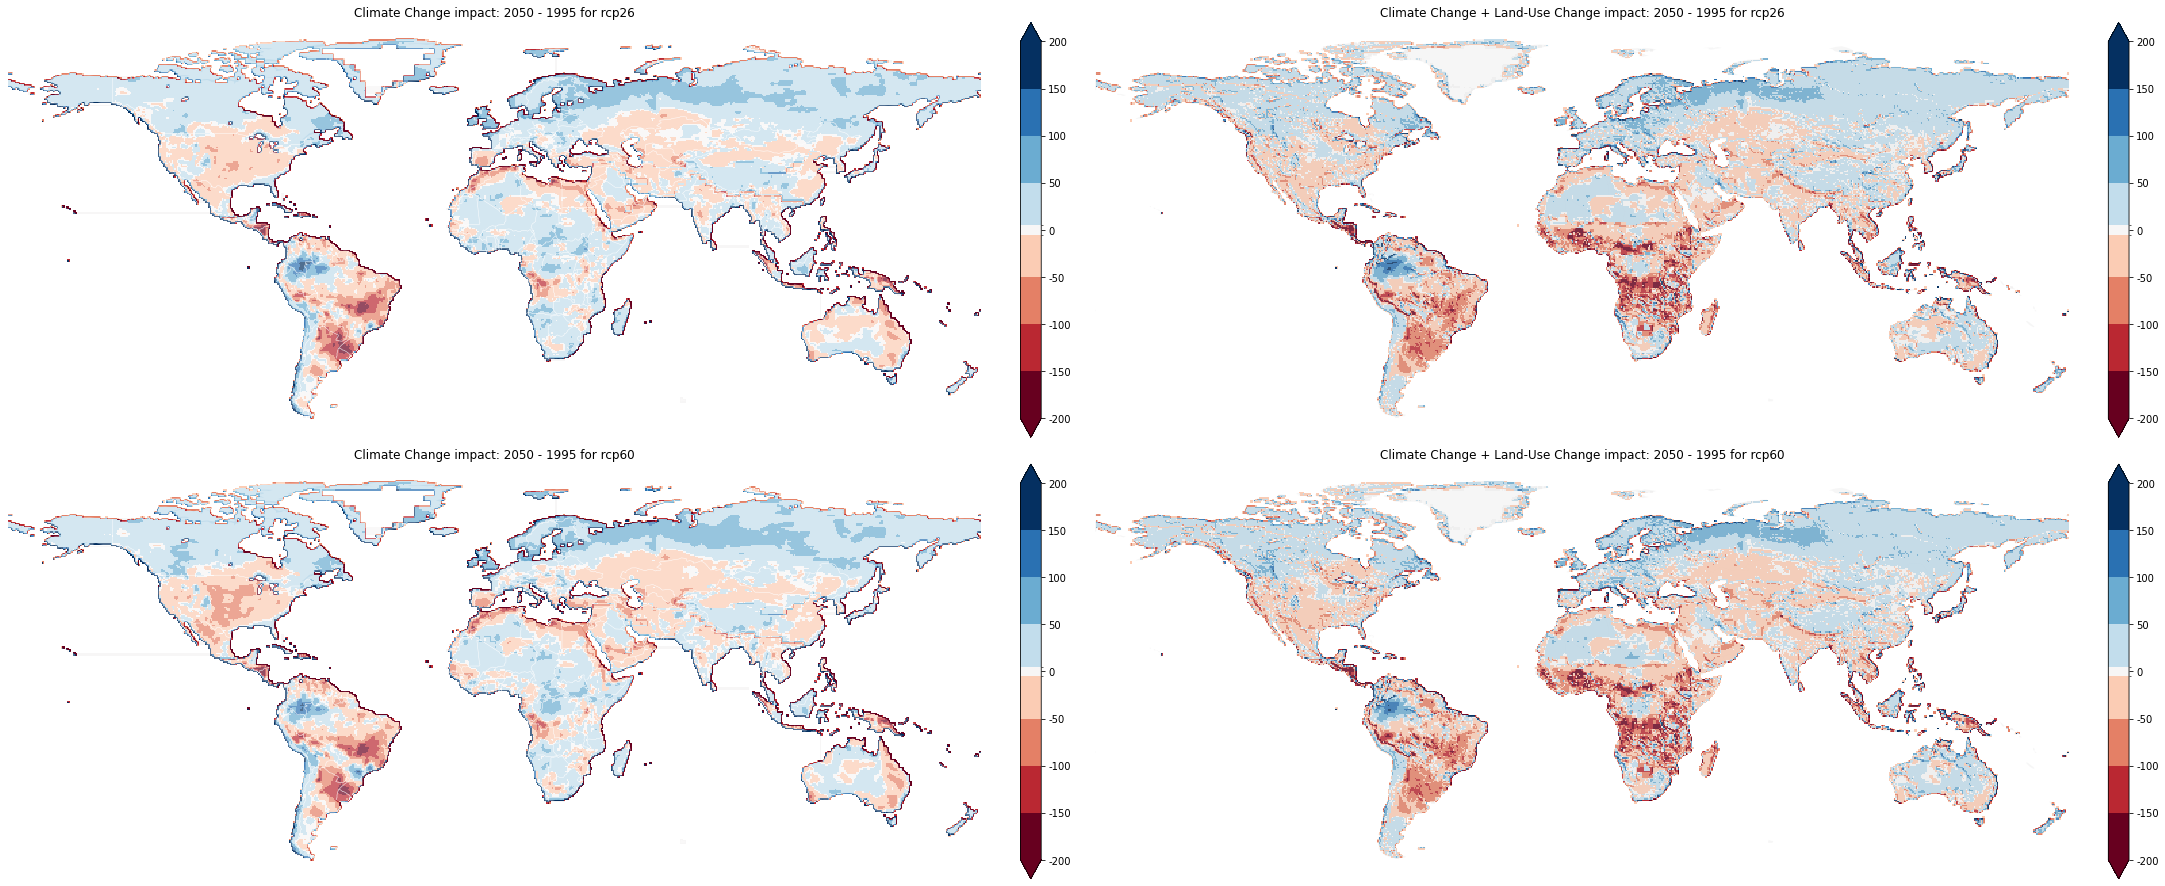

In [124]:
### this code works 

warnings.filterwarnings('ignore', category=UserWarning)

models =  ["GAM"]
taxas = ["Bird","Mammals","Amphibians"]
scenarios = ["rcp26","rcp60"]
historical_time = 1146
future_time=35
model_names = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
years = ['1845', '1990', '1995', '2009', '2010', '2020', '2026', '2032', '2048', '2050','2052', '2056', '2080', '2100', '2150', '2200', '2250']

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(30, 15), subplot_kw={'projection': ccrs.PlateCarree()}, layout="compressed")
cmap = matplotlib.colors.ListedColormap(['white', 'green'])
countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

plot_idx = 0

year_indices = {1146: '1995', 35: '2050', 65: '2080', 85: '2100'}
# Create empty arrays for storing the results for each taxa separately
diff_value_bin_combined_per_taxa = {}
diff_sum_bin_combined_per_taxa = {}
diff_combined_per_taxa = {}


for taxa in taxas:

    diff_value_bin_combined_per_taxa[taxa] = np.zeros([360, 720])
    diff_sum_bin_combined_per_taxa[taxa] = np.zeros([360, 720])
    diff_combined_per_taxa[taxa] = np.zeros([360, 720])

for row, scenario in enumerate(scenarios):

    # Initialize the combined arrays outside the taxa loop
    diff_value_bin_combined = np.zeros([360, 720])
    diff_sum_bin_combined = np.zeros([360, 720])
    diff_combined = np.zeros([360, 720])

    for taxa in taxas:
        # Reset the per model arrays for each taxa
        diff_value_bin_models = []
        diff_sum_bin_models = []
        diff_models = []

        # Your code to calculate diff for each model and taxa here
        for model in models:
            newvalue_hist = f"/storage/scratch/users/ch21o450/data/intermediate_results/{taxa}_{model}_{historical_time}_{scenario}_summedprobs_newvalue.nc"
            sumbin_hist = f"/storage/scratch/users/ch21o450/data/intermediate_results/{taxa}_{model}_{historical_time}_{scenario}_summedprobs_sum.nc"

            #sumbin_hist = f"/storage/homefs/ch21o450/scripts/BioScenComb/intermediate_results/{taxa}_{model}_{historical_time}_{scenario}_species_count_per_SCDM_00th_mean_sum_bin_future.nc"

            mean_value_bin_hist = xr.open_dataset(newvalue_hist, decode_times=False).to_array()
            mean_value_bin_hist = mean_value_bin_hist.isel(variable=0)
            mean_sum_bin_hist = xr.open_dataset(sumbin_hist, decode_times=False).to_array().isel(variable=0)
            

            newvalue_fut = f"/storage/scratch/users/ch21o450/data/intermediate_results/PA_{taxa}_{model}_{future_time}_{scenario}_summedprobs_newvalue.nc"
            sumbin_fut = f"/storage/scratch/users/ch21o450/data/intermediate_results/PA_{taxa}_{model}_{future_time}_{scenario}_summedprobs_sum.nc"
            

            mean_value_bin_future = xr.open_dataset(newvalue_fut, decode_times=False).to_array().isel(variable=0)
            mean_sum_bin_future = xr.open_dataset(sumbin_fut, decode_times=False).to_array()
            mean_sum_bin_future = mean_sum_bin_future.isel(variable=0)

            # Calculate the differences
            diff_value_bin = mean_value_bin_future - mean_value_bin_hist.interp_like(mean_value_bin_future, method='linear')
            diff_sum_bin = mean_sum_bin_future - mean_sum_bin_hist.interp_like(mean_sum_bin_future, method='linear')
            diff = diff_sum_bin - diff_value_bin


            # append the differences to the model-specific lists
            diff_value_bin_models.append(diff_value_bin)
            diff_sum_bin_models.append(diff_sum_bin)
            diff_models.append(diff)


        # The inner loop where diff_value_bin, diff_sum_bin, and diff for each model are calculated should remain intact.

        # Now you concatenate and take mean here for models
        diff_value_bin_ensemble = xr.concat(diff_value_bin_models, dim="ensemble").mean(dim="ensemble")
        diff_sum_bin_ensemble = xr.concat(diff_sum_bin_models, dim="ensemble").mean(dim="ensemble")
        diff_ensemble = diff_sum_bin_ensemble - diff_value_bin_ensemble



    # Append the ensemble mean to the overall results for this taxa
        diff_value_bin_combined_per_taxa[taxa] = diff_value_bin_ensemble
        diff_sum_bin_combined_per_taxa[taxa] = diff_sum_bin_ensemble
        diff_combined_per_taxa[taxa] = diff_ensemble

    # Calculate the overall species richness sum over all taxa
    diff_value_bin_combined = sum(diff_value_bin_combined_per_taxa.values())
    diff_sum_bin_combined = sum(diff_sum_bin_combined_per_taxa.values())
    diff_combined = sum(diff_combined_per_taxa.values())

    diff_newvalue= diff_value_bin_combined
    diff_sumbin = diff_sum_bin_combined
    diff = diff_combined

    # Create subplots for each future time and scenario
    if plot_idx >= len(axes.flatten()):
        break
    ax1 = axes.flatten()[plot_idx]
    ax2 = axes.flatten()[plot_idx + 1]

    labels = ['a', 'b']
    # Define the colormap and the range of values for the colorbar

    vmin_b = diff_sum_bin.min().values
    vmax_b = diff_sum_bin.max().values

    cmap = plt.colormaps['RdBu']
    boundaries = [-200, -150, -100, -50,-5,5,50, 100, 150, 200] # Adjust these values according to your data
    norm = BoundaryNorm(boundaries, cmap.N)

    # Plot the ensemble mean difference for each panel
    im1 = ax1.pcolormesh(diff_newvalue['lon'].values, diff_newvalue['lat'].values, np.where(diff_newvalue.values != 0, diff_newvalue.values, np.nan), transform=ccrs.PlateCarree(), cmap=cmap, norm=norm, antialiased=True)

    countries.plot(ax=ax1, color="white", zorder=1, alpha=0.3)
    ax1.set_title(f"Climate Change impact: {year_indices[future_time]} - 1995 for {scenario}",loc='center')

    ax1.axis('off')
    ax1.set_extent((-180,180,-63,90))
    ax1.add_feature(cfeature.BORDERS,color='white',linewidth=0.5)

    ticks_b = np.array( [-200, -150, -100, -50,0,50, 100, 150, 200])
    tick_labels = [str(int(tick)) for tick in ticks_b]

    cbar1 = plt.colorbar(im1, ax=ax1, fraction=0.024, pad=0.04, spacing='proportional', ticks=ticks_b,extend='both')
    cbar1.set_ticklabels(tick_labels)

    im2 = ax2.pcolormesh(diff_sumbin['lon'].values, diff_sumbin['lat'].values,  np.where(diff_sumbin.values != 0, diff_sumbin.values, np.nan), transform=ccrs.PlateCarree(), cmap=cmap, norm=norm, antialiased=True)

    countries.plot(ax=ax2, color="lightgray", zorder=1, alpha=0.2)

    ax2.set_title(f"Climate Change + Land-Use Change impact: {year_indices[future_time]} - 1995 for {scenario}",loc='center')

    ax2.axis('off')
    ax2.set_extent((-180,180,-63,90))
    cbar2 = plt.colorbar(im2, ax=ax2, fraction=0.024, pad=0.04, spacing='proportional', ticks=ticks_b,extend='both')
    cbar2.set_ticklabels(tick_labels)

    # Increase the plot index by 2 to move to the next triplet of subplots
    plot_idx += 2

    #plt.suptitle(future_time , size=16, y=0.8)
    #plt.savefig("/storage/homefs/ch21o450/scripts/BioScenComb/main_figures/Figure_2")

    #plt.show() 


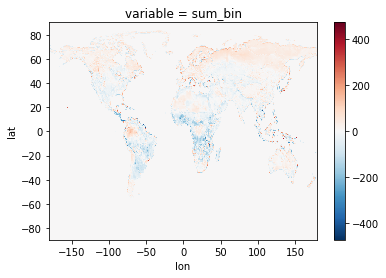

In [116]:
diff_sumbin.plot()

## SDM MODEL ENSEMBLE  ##### 

warnings.filterwarnings('ignore', category=UserWarning)

models =  ["GAM","GBM"]
taxas = ["Bird","Mammals","Amphibians"]
scenarios = ["rcp26","rcp60"]

model_names = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
years = ['1845', '1990', '1995', '2009', '2010', '2020', '2026', '2032', '2048', '2050','2052', '2056', '2080', '2100', '2150', '2200', '2250']

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(30, 15), subplot_kw={'projection': ccrs.PlateCarree()}, layout="compressed")
cmap = matplotlib.colors.ListedColormap(['white', 'green'])
countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

plot_idx = 0

year_indices = {1146: '1995', 35: '2050', 65: '2080', 85: '2100'}
# Create empty arrays for storing the results for each taxa separately
diff_value_bin_combined_per_taxa = {}
diff_sum_bin_combined_per_taxa = {}
diff_combined_per_taxa = {}

for taxa in taxas:
    diff_value_bin_combined_per_taxa[taxa] = np.zeros([360, 720])
    diff_sum_bin_combined_per_taxa[taxa] = np.zeros([360, 720])
    diff_combined_per_taxa[taxa] = np.zeros([360, 720])

for taxa in taxas:
    for scenario in scenarios:
        historical_time = 1146
        future_times = [35]

        year_indices = {1146: '1995', 35: '2050', 65: '2080', 85: '2100'}

        for future_time in future_times:
            diff_value_bin_models = []
            diff_sum_bin_models = []
            diff_models = []
            percent_changes = []


            for model in models:
                newvalue_hist = f"/storage/scratch/users/ch21o450/data/intermediate_results/{taxa}_{model}_{historical_time}_{scenario}_summedprobs_newvalue.nc"
                sumbin_hist = f"/storage/scratch/users/ch21o450/data/intermediate_results/{taxa}_{model}_{historical_time}_{scenario}_summedprobs_sum.nc"
                
                #sumbin_hist = f"/storage/homefs/ch21o450/scripts/BioScenComb/intermediate_results/{taxa}_{model}_{historical_time}_{scenario}_species_count_per_SCDM_00th_mean_sum_bin_future.nc"

                mean_value_bin_hist = xr.open_dataset(newvalue_hist, decode_times=False).to_array()
                mean_sum_bin_hist = xr.open_dataset(sumbin_hist, decode_times=False).to_array()

                newvalue_fut = f"/storage/scratch/users/ch21o450/data/intermediate_results/{taxa}_{model}_{future_time}_{scenario}_summedprobs_newvalue.nc"
                sumbin_fut = f"/storage/scratch/users/ch21o450/data/intermediate_results/{taxa}_{model}_{future_time}_{scenario}_summedprobs_sum.nc"

                mean_value_bin_future = xr.open_dataset(newvalue_fut, decode_times=False).to_array()
                mean_sum_bin_future = xr.open_dataset(sumbin_fut, decode_times=False).to_array()
                mean_sum_bin_future = mean_sum_bin_future.isel(variable=0)

                # Calculate the differences
                diff_value_bin = mean_value_bin_future - mean_value_bin_hist
                diff_sum_bin = mean_sum_bin_future - mean_sum_bin_hist
                diff = diff_sum_bin - diff_value_bin
                change_percent = ((diff_sum_bin - diff_value_bin) / (diff_value_bin)) * 100  # added small value to avoid division by zero
                percent_changes.append(change_percent)

                # append the differences to the model-specific lists
                diff_value_bin_models.append(diff_value_bin)
                diff_sum_bin_models.append(diff_sum_bin)
                diff_models.append(diff)

            # Calculate the ensemble mean outside of the inner loop
            diff_value_bin_ensemble = xr.concat(diff_value_bin_models, dim="ensemble").mean(dim="ensemble")
            diff_sum_bin_ensemble = xr.concat(diff_sum_bin_models, dim="ensemble").mean(dim="ensemble")

            diff_value_bin_ensemble = diff_value_bin_ensemble.isel(variable=0)
            diff_sum_bin_ensemble = diff_sum_bin_ensemble.isel(variable=0)
            diff_ensemble = diff_sum_bin_ensemble - diff_value_bin_ensemble

            # Append the ensemble mean to the overall results for this taxa
            diff_value_bin_combined_per_taxa[taxa] = diff_value_bin_ensemble
            diff_sum_bin_combined_per_taxa[taxa] = diff_sum_bin_ensemble
            diff_combined_per_taxa[taxa] = diff_ensemble

            # Calculate the overall species richness sum over all taxa
            diff_value_bin_combined = sum(diff_value_bin_combined_per_taxa.values())
            diff_sum_bin_combined = sum(diff_sum_bin_combined_per_taxa.values())
            diff_combined = sum(diff_combined_per_taxa.values())


        
            diff_newvalue= diff_value_bin_combined
            diff_sumbin = diff_sum_bin_combined
            diff = diff_combined
            # Create three subplots for each future time and scenario
            if plot_idx >= len(axes.flatten()):
                break
            ax1 = axes.flatten()[plot_idx]
            ax2 = axes.flatten()[plot_idx + 1]

            labels = ['a', 'b']
            # Define the colormap and the range of values for the colorbar
            vmin_b = diff_sum_bin.min().values
            vmax_b = diff_sum_bin.max().values

            cmap = plt.colormaps['RdBu']
            boundaries = [-200, -150, -100, -50,-5,5,50, 100, 150, 200] # Adjust these values according to your data
            norm = BoundaryNorm(boundaries, cmap.N)

            # Plot the ensemble mean difference for each panel
            im1 = ax1.pcolormesh(diff_newvalue['lon'].values, diff_newvalue['lat'].values, np.where(diff_newvalue.values != 0, diff_newvalue.values, np.nan), transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)

            countries.plot(ax=ax1, color="white", zorder=1, alpha=0.3)
            ax1.set_title(f"Climate Change impact: {year_indices[future_time]} - 1995 for {scenario}",loc='center')


            ax1.axis('off')
            ax1.set_extent((-180,180,-63,90))
            ax1.add_feature(cfeature.BORDERS,color='white',linewidth=0.5)

            ticks_b = np.array( [-200, -150, -100, -50,0,50, 100, 150, 200])
            tick_labels = [str(int(tick)) for tick in ticks_b]

            cbar1 = plt.colorbar(im1, ax=ax1, fraction=0.024, pad=0.04, spacing='proportional', ticks=ticks_b,extend='both')
            cbar1.set_ticklabels(tick_labels)



            im2 = ax2.pcolormesh(diff_sumbin['lon'].values, diff_sumbin['lat'].values,  np.where(diff_sumbin.values != 0, diff_sumbin.values, np.nan), transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)

            countries.plot(ax=ax2, color="lightgray", zorder=1, alpha=0.3)

            ax2.set_title(f"Climate Change + Land-Use Change impact: {year_indices[future_time]} - 1995 for {scenario}",loc='center')

            ax2.axis('off')
            ax2.set_extent((-180,180,-63,90))
            cbar2 = plt.colorbar(im2, ax=ax2, fraction=0.024, pad=0.04, spacing='proportional', ticks=ticks_b,extend='both')
            cbar2.set_ticklabels(tick_labels)



            # Increase the plot index by 2 to move to the next triplet of subplots
            plot_idx += 2



            
plt.show() 
